In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
def brier_score(pred_prob, ytrue):
  return np.mean((pred_prob - ytrue)**2)


def brier_score_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    return tf.reduce_mean(tf.math.squared_difference(y_true, y_pred))

In [ ]:
# Read in data and clean it up for testing (i.e. use season averages)
DATA_PATH = 'drive/MyDrive/march_madness_2023/march-machine-learning-mania-2023/'

df = pd.read_csv(DATA_PATH + 'Mfinal_data_2003-2022.csv')
to_drop = [col for col in df.columns if '14' in col]
df.drop(to_drop, axis=1, inplace=True)
df = df[df.Season != 2022]

print(df.shape)
df.head()

(2362, 19)


,Season,TeamIDA,TeamIDB,SeedA,SeedB,OffEffA,DefEffA,EFTA,WinRatioA,GapAvgA,AvgRankA,OffEffB,DefEffB,EFTB,WinRatioB,GapAvgB,AvgRankB,ScoreDiff,WinA
0,2003,1421,1411,16,16,105.315164,115.456256,0.489800,0.448276,-7.241379,259.2,107.187241,105.071425,0.503036,0.600000,1.966667,259.4,8,1
1,2003,1112,1436,1,16,115.232944,95.117513,0.517632,0.892857,14.964286,2.6,106.911164,99.247639,0.494732,0.655172,4.655172,159.6,29,1
2,2003,1113,1272,10,7,113.782349,103.406731,0.517334,0.620690,6.793103,33.6,109.889666,97.004974,0.498337,0.793103,8.689655,21.8,13,1
3,2003,1141,1166,11,6,114.122499,105.421379,0.572835,0.793103,6.103448,43.4,118.566346,96.739284,0.567455,0.878788,14.909091,23.0,6,1
4,2003,1143,1301,8,9,109.611481,102.725168,0.524098,0.724138,4.724138,36.2,111.669631,105.001178,0.534189,0.600000,4.400000,45.0,2,1


In [ ]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import Model, Input
from tensorflow.keras import metrics, regularizers, callbacks

In [ ]:
# Train on data before 2022
to_drop = ['Season', 'TeamIDA', 'TeamIDB', 'ScoreDiff', 'WinA']
X = df.drop(to_drop, axis=1)
Y = df['WinA']

# Split into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

# Use standard scaler on features
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# scaler = StandardScaler()
# scaler.fit(X)
# X_scaled = scaler.transform(X)

# Shrinking layers, small
inputs = Input(shape=(14,))
x = Dense(64, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
# x = Dense(32, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs, name='shrink_small')

model.compile(optimizer='adam', 
              loss=brier_score_loss, 
              metrics=[metrics.BinaryCrossentropy()
              ])
history = model.fit(X_train_scaled, Y_train, 
                    batch_size=32, epochs=300, 
                    validation_data=(X_test_scaled, Y_test),
                    callbacks=callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=25),
                    verbose=1)

Epoch 1/300
52/52 [==============================] - 6s 17ms/step - loss: 1.9915 - binary_crossentropy: 5.2330 - val_loss: 0.3274 - val_binary_crossentropy: 1.3211
Epoch 2/300
52/52 [==============================] - 1s 10ms/step - loss: 1.0421 - binary_crossentropy: 4.1622 - val_loss: 0.2454 - val_binary_crossentropy: 0.7836
Epoch 3/300
52/52 [==============================] - 0s 7ms/step - loss: 0.8245 - binary_crossentropy: 3.6715 - val_loss: 0.2453 - val_binary_crossentropy: 0.8466
Epoch 4/300
52/52 [==============================] - 0s 6ms/step - loss: 0.6512 - binary_crossentropy: 3.2163 - val_loss: 0.2428 - val_binary_crossentropy: 0.9059
Epoch 5/300
52/52 [==============================] - 0s 7ms/step - loss: 0.5799 - binary_crossentropy: 3.0871 - val_loss: 0.2367 - val_binary_crossentropy: 0.7884
Epoch 6/300
52/52 [==============================] - 0s 7ms/step - loss: 0.5142 - binary_crossentropy: 2.5728 - val_loss: 0.2319 - val_binary_crossentropy: 0.7595
Epoch 7/300
52/52 [=

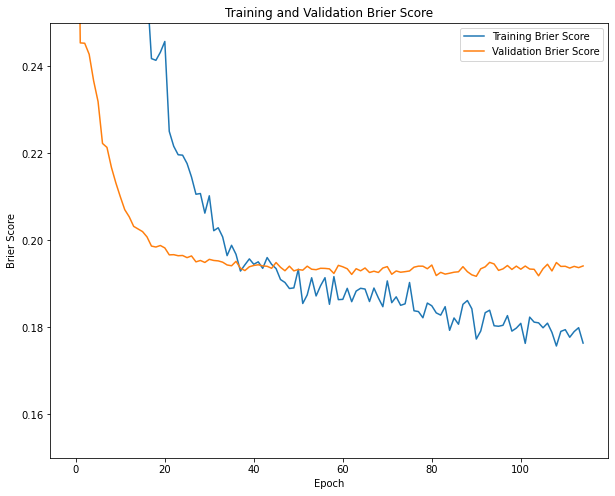

In [ ]:
# Plot the loss
fig = plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='Training Brier Score')
plt.plot(history.history['val_loss'], label='Validation Brier Score')
plt.title('Training and Validation Brier Score')
plt.xlabel('Epoch')
plt.ylabel('Brier Score')
plt.ylim(0.15,0.25)
plt.legend()
plt.show()

In [ ]:
# Read in Team names
df_teams = pd.read_csv(DATA_PATH + 'MTeams.csv')
df_teams = df_teams[df_teams['FirstD1Season'] < 2023]
df_teams = df_teams.drop(['FirstD1Season', 'LastD1Season'], axis=1)

print(df_teams.shape)
df_teams.head()

(372, 2)


,TeamID,TeamName
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M


In [ ]:
# Read in Seeds for 2022 bracket
df_seeds = pd.read_csv(DATA_PATH + 'MNCAATourneySeeds.csv')
df_seeds = df_seeds[df_seeds.Season == 2022]

def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

df_seeds['Seed'] = df_seeds['Seed'].apply(treat_seed)
    
df_seeds.head()

,Season,Seed,TeamID
2354,2022,1,1124
2355,2022,2,1246
2356,2022,3,1345
2357,2022,4,1417
2358,2022,5,1388


In [ ]:
# Read in 2022 data for testing
df_features = pd.read_csv(DATA_PATH + 'Mtesting_features_2022.csv')

print(df_features.shape)
df_features.head()

(358, 9)


,Season,TeamID,Seed,OffEff,DefEff,EFT,WinRatio,GapAvg,AvgRank
0,2022,1101,17.0,104.729843,98.372753,0.478187,0.655172,4.758621,126.0
1,2022,1102,17.0,98.104888,110.105134,0.510235,0.379310,-7.000000,254.8
2,2022,1103,13.0,111.213841,102.930732,0.531191,0.709677,5.129032,116.8
3,2022,1104,6.0,111.296064,106.256847,0.515820,0.593750,3.562500,26.6
4,2022,1105,17.0,90.740317,98.383173,0.415887,0.400000,-5.566667,320.6


In [ ]:
def get_game_data(teamA, teamB, teams, features):

  if teamA not in teams.TeamName.tolist():
    raise NameError('{} not in team names csv'.format(teamA))
  if teamB not in teams.TeamName.tolist():
    raise NameError('{} not in team names csv'.format(teamB))

  teamA = teams[teams.TeamName == teamA].drop(['TeamName'], axis=1)
  teamB = teams[teams.TeamName == teamB].drop(['TeamName'], axis=1)
  
  teamA = pd.merge(teamA, features, on='TeamID', how='left')
  teamB = pd.merge(teamB, features, on='TeamID', how='left').drop('Season', axis=1)

  teamA.rename(columns={
      'TeamID' : 'TeamIDA',
      'Seed' : 'SeedA',
      'OffEff' : 'OffEffA',
      'DefEff' : 'DefEffA',
      'EFT' : 'EFTA',
      'WinRatio' : 'WinRatioA',
      'GapAvg' : 'GapAvgA',
      'AvgRank' : 'AvgRankA' 
  }, inplace=True)

  teamB.rename(columns={
      'TeamID' : 'TeamIDB',
      'Seed' : 'SeedB',
      'OffEff' : 'OffEffB',
      'DefEff' : 'DefEffB',
      'EFT' : 'EFTB',
      'WinRatio' : 'WinRatioB',
      'GapAvg' : 'GapAvgB',
      'AvgRank' : 'AvgRankB' 
  }, inplace=True)

  game = pd.concat([teamA, teamB], axis=1)
  cols = ['Season', 'TeamIDA', 'TeamIDB', 'SeedA', 'SeedB',
          'OffEffA', 'DefEffA', 'EFTA', 'WinRatioA', 'GapAvgA',
          'AvgRankA', 'OffEffB', 'DefEffB', 'EFTB', 'WinRatioB',
          'GapAvgB', 'AvgRankB']
  game = game[cols]

  return game


def get_seeds(team1_name, team2_name, teams, seeds):
    
    if team1_name not in teams.TeamName.tolist():
      raise NameError('{} not in team names csv'.format(team1_name))
    if team2_name not in teams.TeamName.tolist():
      raise NameError('{} not in team names csv'.format(team2_name))

    teamA = teams[teams.TeamName == team1_name]
    teamB = teams[teams.TeamName == team2_name]

    teamA = pd.merge(teamA, seeds, on='TeamID', how='left')
    teamB = pd.merge(teamB, seeds, on='TeamID', how='left')

    return teamA.Seed.tolist()[0], teamB.Seed.tolist()[0]

In [ ]:
# Input arrays for 2022 bracket
round_of_64 = [
    ['Gonzaga',        'Georgia St'],
    ['Boise St',    'Memphis'],
    ['Connecticut',    'New Mexico St'],
    ['Arkansas',       'Vermont'],
    ['Alabama',        'Notre Dame'],
    ['Texas Tech',     'Montana St'],
    ['Michigan St',    'Davidson'],
    ['Duke',           'CS Fullerton'],
    ['Baylor',         'Norfolk St'],
    ['North Carolina', 'Marquette'],
    ["St Mary's CA",    'Indiana'],
    ['UCLA',           'Akron'],
    ['Texas',          'Virginia Tech'],
    ['Purdue',         'Yale'],
    ['Murray St',      'San Francisco'],
    ['Kentucky',       "St Peter's"],
    ['Arizona',        'Wright St'],
    ['Seton Hall',     'TCU'],
    ['Houston',        'UAB'],
    ['Illinois',       'Chattanooga'],
    ['Colorado St',    'Michigan'],
    ['Tennessee',      'Longwood'],
    ['Ohio St',        'Loyola-Chicago'],
    ['Villanova',      'Delaware'],
    ['Kansas',         'TX Southern'],
    ['San Diego St',   'Creighton'],
    ['Iowa',           'Richmond'],
    ['Providence',     'S Dakota St'],
    ['LSU',            'Iowa St'],
    ['Wisconsin',      'Colgate'],
    ['USC',            'Miami FL'],
    ['Auburn',         'Jacksonville St']
]

round_of_32 = [
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B']
]

sweet_16 = [
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B']
]

elite_8 = [
    ['A','B'],
    ['A','B'],
    ['A','B'],
    ['A','B']
]

final_4 = [
    ['A','B'],
    ['A','B']
]

ship = ['A','B']

In [ ]:
# Predict Round of 64
# Generate Round of 64 games
games_64 = pd.DataFrame()
for g,teams in enumerate(round_of_64):
    games_64 = pd.concat([games_64, get_game_data(teams[0], teams[1], df_teams, df_features)])    

games_64 = games_64.drop(['Season', 'TeamIDA', 'TeamIDB'], axis=1)
game_X = scaler.transform(games_64)
preds = model.predict(game_X, verbose=0)

print('-- Round of 64 --')
i = 0
j = 0
regions = ['West','East','South','Midwest']
for g,teams in enumerate(round_of_64):
    if g % 8 == 0:
        print('\n%s Region:' %(regions[i]))
        i += 1
                
    s1, s2 = get_seeds(teams[0], teams[1], df_teams, df_seeds)
            
    if preds[g] >= 0.5:
        
        if g % 2 == 0:
            round_of_32[j][0] = teams[0]
        elif g % 2 == 1:
            round_of_32[j][1] = teams[0]
            j += 1
        
        print('%s (%d) beats %s (%d) with probability: %.4f' % (teams[0], s1, teams[1], s2, preds[g]))

    else:
        
        if g % 2 == 0:
            round_of_32[j][0] = teams[1]
        elif g % 2 == 1:
            round_of_32[j][1] = teams[1]
            j += 1
            
        print('%s (%d) beats %s (%d) with probability: %.4f' % (teams[1], s2, teams[0], s1, 1-preds[g]))


-- Round of 64 --

West Region:
Gonzaga (1) beats Georgia St (16) with probability: 1.0493
Memphis (9) beats Boise St (8) with probability: 0.5715
Connecticut (5) beats New Mexico St (12) with probability: 0.7810
Arkansas (4) beats Vermont (13) with probability: 0.7458
Alabama (6) beats Notre Dame (11) with probability: 0.6050
Texas Tech (3) beats Montana St (14) with probability: 0.8394
Michigan St (7) beats Davidson (10) with probability: 0.5774
Duke (2) beats CS Fullerton (15) with probability: 0.9640

East Region:
Baylor (1) beats Norfolk St (16) with probability: 0.9667
Marquette (9) beats North Carolina (8) with probability: 0.5467
Indiana (12) beats St Mary's CA (5) with probability: 0.6192
UCLA (4) beats Akron (13) with probability: 0.9119
Texas (6) beats Virginia Tech (11) with probability: 0.5556
Purdue (3) beats Yale (14) with probability: 0.8685
Murray St (7) beats San Francisco (10) with probability: 0.6763
Kentucky (2) beats St Peter's (15) with probability: 0.8933

South

In [ ]:
# Predict Round of 32
# Generate Round of 32 games
games_32 = pd.DataFrame()
for g,teams in enumerate(round_of_32):
    games_32 = pd.concat([games_32, get_game_data(teams[0], teams[1], df_teams, df_features)])    

games_32 = games_32.drop(['Season', 'TeamIDA', 'TeamIDB'], axis=1)
game_X = scaler.transform(games_32)
preds = model.predict(game_X, verbose=0)

print('-- Round of 32 --')
i = 0
j = 0
regions = ['West','East','South','Midwest']
for g,teams in enumerate(round_of_32):
    if g % 4 == 0:
        print('\n%s Region:' %(regions[i]))
        i += 1
                
    s1, s2 = get_seeds(teams[0], teams[1], df_teams, df_seeds)
            
    if preds[g] >= 0.5:
        
        if g % 2 == 0:
            sweet_16[j][0] = teams[0]
        elif g % 2 == 1:
            sweet_16[j][1] = teams[0]
            j += 1
        
        print('%s (%d) beats %s (%d) with probability: %.4f' % (teams[0], s1, teams[1], s2, preds[g]))

    else:
        
        if g % 2 == 0:
            sweet_16[j][0] = teams[1]
        elif g % 2 == 1:
            sweet_16[j][1] = teams[1]
            j += 1
            
        print('%s (%d) beats %s (%d) with probability: %.4f' % (teams[1], s2, teams[0], s1, 1-preds[g]))


-- Round of 32 --

West Region:
Gonzaga (1) beats Memphis (9) with probability: 0.8806
Connecticut (5) beats Arkansas (4) with probability: 0.6065
Texas Tech (3) beats Alabama (6) with probability: 0.6395
Duke (2) beats Michigan St (7) with probability: 0.7624

East Region:
Baylor (1) beats Marquette (9) with probability: 0.7562
UCLA (4) beats Indiana (12) with probability: 0.7293
Texas (6) beats Purdue (3) with probability: 0.5292
Kentucky (2) beats Murray St (7) with probability: 0.7079

South Region:
Arizona (1) beats Seton Hall (8) with probability: 0.8637
Houston (5) beats Illinois (4) with probability: 0.6757
Tennessee (3) beats Michigan (11) with probability: 0.6922
Villanova (2) beats Loyola-Chicago (10) with probability: 0.5798

Midwest Region:
Kansas (1) beats San Diego St (8) with probability: 0.5658
Iowa (5) beats Providence (4) with probability: 0.6203
Wisconsin (3) beats Iowa St (11) with probability: 0.5145
Auburn (2) beats USC (7) with probability: 0.5445


In [ ]:
# Predict Sweet 16
# Generate Sweet 16 games
games_16 = pd.DataFrame()
for g,teams in enumerate(sweet_16):
    games_16 = pd.concat([games_16, get_game_data(teams[0], teams[1], df_teams, df_features)])    

games_16 = games_16.drop(['Season', 'TeamIDA', 'TeamIDB'], axis=1)
game_X = scaler.transform(games_16)
preds = model.predict(game_X, verbose=0)

print('-- Sweet 16 --')
i = 0
j = 0
regions = ['West','East','South','Midwest']
for g,teams in enumerate(sweet_16):
    if g % 2 == 0:
        print('\n%s Region:' %(regions[i]))
        i += 1
                
    s1, s2 = get_seeds(teams[0], teams[1], df_teams, df_seeds)
            
    if preds[g] >= 0.5:
        
        if g % 2 == 0:
            elite_8[j][0] = teams[0]
        elif g % 2 == 1:
            elite_8[j][1] = teams[0]
            j += 1
        
        print('%s (%d) beats %s (%d) with probability: %.4f' % (teams[0], s1, teams[1], s2, preds[g]))

    else:
        
        if g % 2 == 0:
            elite_8[j][0] = teams[1]
        elif g % 2 == 1:
            elite_8[j][1] = teams[1]
            j += 1
            
        print('%s (%d) beats %s (%d) with probability: %.4f' % (teams[1], s2, teams[0], s1, 1-preds[g]))


-- Sweet 16 --

West Region:
Gonzaga (1) beats Connecticut (5) with probability: 0.7775
Duke (2) beats Texas Tech (3) with probability: 0.5150

East Region:
Baylor (1) beats UCLA (4) with probability: 0.6117
Kentucky (2) beats Texas (6) with probability: 0.6750

South Region:
Arizona (1) beats Houston (5) with probability: 0.7319
Tennessee (3) beats Villanova (2) with probability: 0.5489

Midwest Region:
Kansas (1) beats Iowa (5) with probability: 0.6433
Auburn (2) beats Wisconsin (3) with probability: 0.6091


In [ ]:
# Predict Elite 8 games
# Generate Elite 8 games
games_8 = pd.DataFrame()
for g,teams in enumerate(elite_8):
    games_8 = pd.concat([games_8, get_game_data(teams[0], teams[1], df_teams, df_features)])    

games_8 = games_8.drop(['Season', 'TeamIDA', 'TeamIDB'], axis=1)
game_X = scaler.transform(games_8)
preds = model.predict(game_X, verbose=0)

print('-- Elite 8 --')
i = 0
j = 0
regions = ['West','East','South','Midwest']
for g,teams in enumerate(elite_8):
    if g % 1 == 0:
        print('\n%s Region:' %(regions[i]))
        i += 1
                
    s1, s2 = get_seeds(teams[0], teams[1], df_teams, df_seeds)
            
    if preds[g] >= 0.5:
        
        if g % 2 == 0:
            final_4[j][0] = teams[0]
        elif g % 2 == 1:
            final_4[j][1] = teams[0]
            j += 1
        
        print('%s (%d) beats %s (%d) with probability: %.4f' % (teams[0], s1, teams[1], s2, preds[g]))

    else:
        
        if g % 2 == 0:
            final_4[j][0] = teams[1]
        elif g % 2 == 1:
            final_4[j][1] = teams[1]
            j += 1
            
        print('%s (%d) beats %s (%d) with probability: %.4f' % (teams[1], s2, teams[0], s1, 1-preds[g]))


-- Elite 8 --

West Region:
Gonzaga (1) beats Duke (2) with probability: 0.6162

East Region:
Kentucky (2) beats Baylor (1) with probability: 0.5267

South Region:
Arizona (1) beats Tennessee (3) with probability: 0.7235

Midwest Region:
Kansas (1) beats Auburn (2) with probability: 0.5775


In [ ]:
# Predict Final Four
# Generate Final Four games
games_4 = pd.DataFrame()
for g,teams in enumerate(final_4):
    games_4 = pd.concat([games_4, get_game_data(teams[0], teams[1], df_teams, df_features)])    

games_4 = games_4.drop(['Season', 'TeamIDA', 'TeamIDB'], axis=1)
game_X = scaler.transform(games_4)
preds = model.predict(game_X, verbose=0)

print('-- Final Four --')
i = 0
regions = ['West','East','South','Midwest']
for g,teams in enumerate(final_4):
                
    s1, s2 = get_seeds(teams[0], teams[1], df_teams, df_seeds)
            
    if preds[g] >= 0.5:
        
        ship[i] = teams[0]
        print('%s (%d) beats %s (%d) with probability: %.4f' % (teams[0], s1, teams[1], s2, preds[g]))

    else:
        
        ship[i] = teams[1]   
        print('%s (%d) beats %s (%d) with probability: %.4f' % (teams[1], s2, teams[0], s1, 1-preds[g]))

    i += 1


-- Final Four --
Gonzaga (1) beats Kentucky (2) with probability: 0.6042
Arizona (1) beats Kansas (1) with probability: 0.5600


In [ ]:
# Predict Championship
# Generate Championship game
champ = get_game_data(ship[0], ship[1], df_teams, df_features)

champ = champ.drop(['Season', 'TeamIDA', 'TeamIDB'], axis=1)
game_X = scaler.transform(champ)
preds = model.predict(game_X, verbose=0)

teams = ship
s1, s2 = get_seeds(teams[0], teams[1], df_teams, df_seeds)

if preds >= 0.5:
    print('%s (%d) beats %s (%d) with probability: %.4f' % (teams[0], s1, teams[1], s2, preds))

else:
    print('%s (%d) beats %s (%d) with probability: %.4f' % (teams[1], s2, teams[0], s1, 1-preds))

    

Gonzaga (1) beats Arizona (1) with probability: 0.5394


In [ ]:
# Predict the championship score 
# Average winning championship score from 2003 - 2021
# Average losing championship score from 2003 - 2021
t = pd.read_csv(DATA_PATH + 'MNCAATourneyDetailedResults.csv')
t = t[t.Season < 2022]
t = t[t.DayNum == 154] # only look at championships
print('Average winning score: {:.4f}'.format(t.WScore.mean()))
print('Average losing score: {:.4f}'.format(t.LScore.mean()))
print('Total average score: {:.4f}'.format(t.WScore.mean() + t.LScore.mean()))

Average winning score: 74.8889
Average losing score: 66.2778
Total average score: 141.1667


In [ ]:
from tqdm import tqdm

print('Gathering all maatchup data...')
games = pd.DataFrame()
preds = []
for teamA in tqdm(df_teams.TeamID):
  for teamB in df_teams.TeamID:
    if teamA < teamB:
      teamA_name = df_teams[df_teams.TeamID == teamA].TeamName.tolist()[0]
      teamB_name = df_teams[df_teams.TeamID == teamB].TeamName.tolist()[0]
      game = get_game_data(teamA_name, teamB_name, df_teams, df_features)
      games = pd.concat([games, game])

print('Creating submission IDs...')    
games.dropna(inplace=True)
sub_ids = []
for teamA in tqdm(games.TeamIDA):
  for teamB in games.TeamIDB:
    if teamA < teamB:
      sub_ids.append('2022_{:d}_{:d}'.format(teamA, teamB))

print('Making predictions...')
games.drop(['Season', 'TeamIDA', 'TeamIDB'], axis=1, inplace=True)
game_X = scaler.transform(games)
preds = model.predict(game_X, verbose=0)

submission = {}
submission['ID'] = sub_ids
submission['Pred'] = preds
submission = pd.DataFrame(submission)

100%|██████████| 372/372 [13:58<00:00,  2.25s/it]


In [ ]:
submission = pd.DataFrame(submission)
submission

NameError: ignored